In [ ]:
# Check GPU type
!nvidia-smi

Thu Jan  9 07:06:53 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
# Install ultralytics
!pip -q install  ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 54.9 MB/s eta 0:00:00


In [ ]:
# Import libraries
import pandas as pd
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO
import multiprocessing

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
!gdown 16T40TdpaB8VXohm50SySREwrzbuPcJBC
!mkdir -p data/images
!unzip -qqnd data/images images.zip

Downloading...
From (original): https://drive.google.com/uc?id=16T40TdpaB8VXohm50SySREwrzbuPcJBC
From (redirected): https://drive.google.com/uc?id=16T40TdpaB8VXohm50SySREwrzbuPcJBC&confirm=t&uuid=afb04cec-d195-463c-b75c-c81f137abb80
To: /content/images.zip
100% 4.29G/4.29G [00:41<00:00, 104MB/s] 


In [ ]:
# Path to where your data is stored
DATA_DIR = Path('/content/data')

# Preview data files available
os.listdir(DATA_DIR)

['images']

In [ ]:
# Set up directoris for training a yolo model

# Images directories
DATASET_DIR = Path('datasets/dataset')
IMAGES_DIR = DATASET_DIR / 'images'
TRAIN_IMAGES_DIR = IMAGES_DIR / 'train'
VAL_IMAGES_DIR = IMAGES_DIR / 'val'
TEST_IMAGES_DIR = IMAGES_DIR / 'test'

# Labels directories
LABELS_DIR = DATASET_DIR / 'labels'
TRAIN_LABELS_DIR = LABELS_DIR / 'train'
VAL_LABELS_DIR = LABELS_DIR / 'val'
TEST_LABELS_DIR = LABELS_DIR / 'test'

In [ ]:
# # Unzip images to 'images' dir
# shutil.unpack_archive(DATA_DIR / 'images.zip', 'images')

In [ ]:
# Load train and test files
train = pd.read_csv(DATA_DIR / 'Train.csv')
test = pd.read_csv(DATA_DIR / 'Test.csv')
ss = pd.read_csv(DATA_DIR / 'SampleSubmission.csv')

# Add an image_path column
train['image_path'] = [Path('/content/data/images/' + x) for x in train.Image_ID]
test['image_path'] = [Path('/content/data/images/' + x) for x in test.Image_ID]

# Map str classes to ints (label encoding targets)
train['class_id'] = train['class'].map({'Trophozoite': 0, 'WBC': 1, 'NEG': 2})

# Preview the head of the train set
train.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax,image_path,class_id
0,id_u3q6jdck4j.jpg,Trophozoite,1.0,712,1241,737,1270,/content/data/images/id_u3q6jdck4j.jpg,0
1,id_a6cl90trri.jpg,Trophozoite,1.0,558,1566,600,1604,/content/data/images/id_a6cl90trri.jpg,0
2,id_qvc2le9sm8.jpg,Trophozoite,1.0,1317,2788,1448,2914,/content/data/images/id_qvc2le9sm8.jpg,0
3,id_w8xnbd5rvm.jpg,Trophozoite,1.0,925,1744,1041,1823,/content/data/images/id_w8xnbd5rvm.jpg,0
4,id_6dop09rk02.jpg,NEG,1.0,0,0,0,0,/content/data/images/id_6dop09rk02.jpg,2


In [ ]:
# Filter out NEG class (Negative images - this images have no Trophozoite nor WBC in them)
# Yolo reccomends that when creating labels for negative images, you leave them empty
# https://github.com/ultralytics/yolov5/issues/3218
# As this is a starter nb, we will ignore the negative images
train = train[~(train['class'] == 'NEG')].reset_index(drop = True)

In [ ]:
# Split data into training and validation
train_unique_imgs_df = train.drop_duplicates(subset = ['Image_ID'], ignore_index = True)
X_train, X_val = train_test_split(train_unique_imgs_df, test_size = 0.25, stratify=train_unique_imgs_df['class'], random_state=42)

X_train = train[train.Image_ID.isin(X_train.Image_ID)]
X_val = train[train.Image_ID.isin(X_val.Image_ID)]

# Check shapes of training and validation data
X_train.shape, X_val.shape

((17354, 9), (5488, 9))

In [ ]:
# Preview target distribution, seems there a class imbalance that needs to be handled
X_train['class'].value_counts(normalize = True), X_val['class'].value_counts(normalize = True)

(class
 Trophozoite    0.688141
 WBC            0.311859
 Name: proportion, dtype: float64,
 class
 Trophozoite    0.709913
 WBC            0.290087
 Name: proportion, dtype: float64)

In [ ]:
# Check if dirs exist, if they do, remove them, otherwise create them.
# This only needs to run once
for DIR in [TRAIN_IMAGES_DIR,VAL_IMAGES_DIR, TEST_IMAGES_DIR, TRAIN_LABELS_DIR,VAL_LABELS_DIR,TEST_LABELS_DIR]:
  if DIR.exists():
    shutil.rmtree(DIR)
  DIR.mkdir(parents=True, exist_ok = True)

In [ ]:
# Copy train, val and test images to their respective dirs
for img in tqdm(X_train.image_path.unique()):
  shutil.copy(img, TRAIN_IMAGES_DIR / img.parts[-1])

for img in tqdm(X_val.image_path.unique()):
  shutil.copy(img, VAL_IMAGES_DIR / img.parts[-1])

for img in tqdm(test.image_path.unique()):
  shutil.copy(img, TEST_IMAGES_DIR / img.parts[-1])

  0%|          | 0/1544 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/1178 [00:00<?, ?it/s]

In [ ]:
# Function to convert the bboxes to yolo format and save them
def save_yolo_annotation(row):
    image_path, class_id, output_dir = row['image_path'], row['class_id'], row['output_dir']

    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image from path: {image_path}")

    height, width, _ = img.shape

    label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"

    ymin, xmin, ymax, xmax = row['ymin'], row['xmin'], row['ymax'], row['xmax']

    # Normalize the coordinates
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    with open(label_file, 'a') as f:
        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

# Parallelize the annotation saving process
def process_dataset(dataframe, output_dir):
    dataframe['output_dir'] = output_dir
    with multiprocessing.Pool() as pool:
        list(tqdm(pool.imap(save_yolo_annotation, dataframe.to_dict('records')), total=len(dataframe)))

# Save train and validation labels to their respective dirs
process_dataset(X_train, TRAIN_LABELS_DIR)
process_dataset(X_val, VAL_LABELS_DIR)

<ipython-input-18-f4a829c8e24a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['output_dir'] = output_dir


  0%|          | 0/17354 [00:00<?, ?it/s]

<ipython-input-18-f4a829c8e24a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['output_dir'] = output_dir


  0%|          | 0/5488 [00:00<?, ?it/s]

In [ ]:
# Train images dir
TRAIN_IMAGES_DIR

PosixPath('datasets/dataset/images/train')

In [ ]:
# Create a data.yaml file required by yolo
class_names = train['class'].unique().tolist()
num_classes = len(class_names)

data_yaml = {
    'train': '/content/' + str(TRAIN_IMAGES_DIR),
    'val': '/content/' + str(VAL_IMAGES_DIR),
    'test': '/content/' + str(TEST_IMAGES_DIR),
    'nc': num_classes,
    'names': class_names
}

yaml_path = 'data.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Preview data yaml file
data_yaml

{'train': '/content/datasets/dataset/images/train',
 'val': '/content/datasets/dataset/images/val',
 'test': '/content/datasets/dataset/images/test',
 'nc': 2,
 'names': ['Trophozoite', 'WBC']}

Plotting id_iwm2km59xp.jpg with 10 bounding boxes.


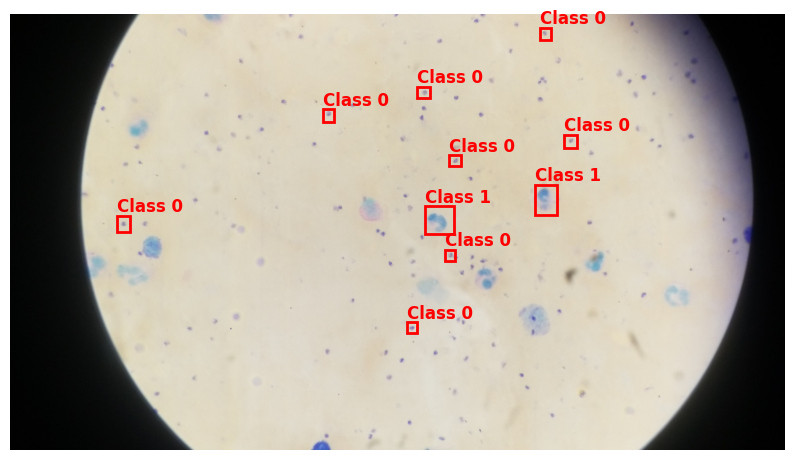

Plotting id_tmtzoe9bns.jpg with 85 bounding boxes.


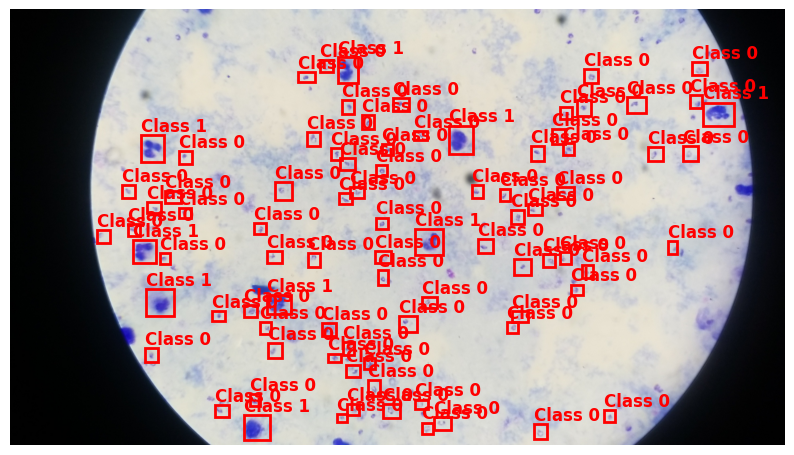

Plotting id_oquldbwuzd.jpg with 2 bounding boxes.


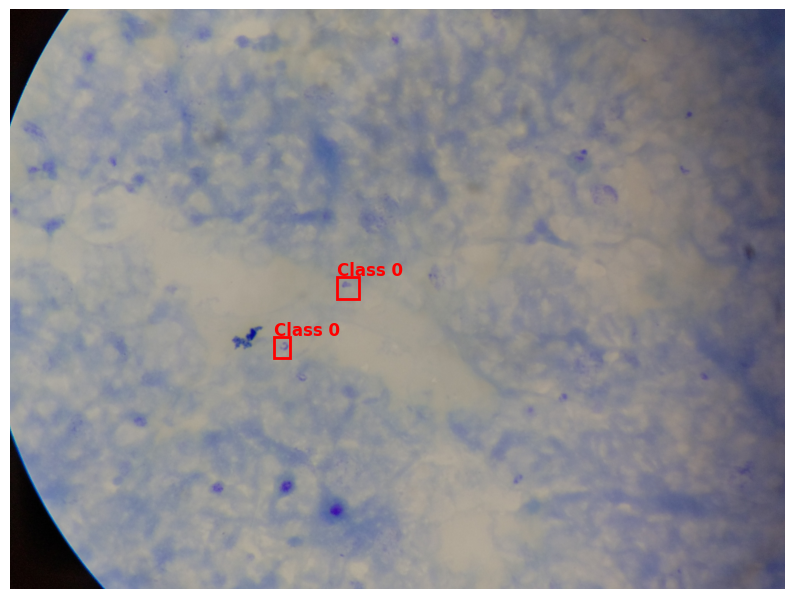

In [ ]:
# Plot some images and their bboxes to ensure the conversion was done correctly
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get image dimensions
    h, w, _ = image.shape

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        # Convert YOLO format to corner coordinates
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 10, f'Class {int(class_id)}', color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

# Directories for images and labels
IMAGE_DIR = TRAIN_IMAGES_DIR
LABEL_DIR = TRAIN_LABELS_DIR

# Plot a few images with their annotations
for image_name in os.listdir(IMAGE_DIR)[:3]:
    image_path = IMAGE_DIR / image_name
    label_path = LABEL_DIR / (image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    if label_path.exists():
        boxes = load_annotations(label_path)
        print(f"Plotting {image_name} with {len(boxes)} bounding boxes.")
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No annotations found for {image_name}.")


In [ ]:
# Load a yolo pretrained model
model = YOLO('yolov11m.pt')

# Fine tune model to our data
model.train(
    data='/content/data.yaml',         # Path to the dataset configuration
    epochs = 100,                         # Number of epochs
    imgsz = 1024,                         # Image size (height, width)
    batch = 8,  #8                        # Batch size
    device = 0,                           # Device to use (0 for the first GPU)
    patience = 10                          # Device to use (0 for the first GPU)
    )

Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/data.yaml, epochs=50, time=None, patience=10, batch=4, imgsz=2048, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

train: Scanning /content/datasets/dataset/labels/train.cache... 1544 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1544/1544 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/dataset/labels/val.cache... 515 images, 0 backgrounds, 0 corrupt: 100%|██████████| 515/515 [00:00<?, ?it/s]


Plotting labels to runs/detect/train11/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 2048 train, 2048 val
Using 8 dataloader workers
Logging results to runs/detect/train11
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      41.8G      1.905      2.079      1.645         87       2048: 100%|██████████| 386/386 [02:23<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:15<00:00,  4.26it/s]


                   all        515       5488      0.919      0.389      0.599       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      24.7G      1.894      1.524      1.652         51       2048: 100%|██████████| 386/386 [02:19<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:12<00:00,  5.13it/s]

                   all        515       5488      0.585      0.654      0.646       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      25.1G      1.885      1.533      1.639         97       2048: 100%|██████████| 386/386 [02:19<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:12<00:00,  5.33it/s]

                   all        515       5488      0.602      0.647      0.658      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      26.1G      1.881      1.517      1.632         38       2048: 100%|██████████| 386/386 [02:19<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.46it/s]

                   all        515       5488      0.695      0.724      0.737      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      25.1G      1.832      1.411      1.625         51       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:12<00:00,  5.41it/s]

                   all        515       5488      0.601      0.693      0.711      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      24.5G      1.835      1.381      1.609         39       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.43it/s]

                   all        515       5488      0.726      0.734      0.757      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      25.3G      1.837      1.326      1.616         43       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.46it/s]

                   all        515       5488      0.706      0.679      0.711      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      24.4G      1.823      1.354      1.586         98       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.44it/s]

                   all        515       5488      0.761      0.748      0.784      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      25.1G      1.821      1.323      1.596         27       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.48it/s]

                   all        515       5488      0.736      0.701      0.745      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      24.8G       1.82      1.278      1.578         27       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.46it/s]

                   all        515       5488      0.737      0.748      0.776      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      25.2G       1.81      1.255      1.588         41       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.50it/s]

                   all        515       5488      0.742      0.766      0.778      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      24.8G      1.786      1.228       1.57         55       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:12<00:00,  5.38it/s]

                   all        515       5488      0.756      0.797      0.807      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      24.3G      1.789      1.199      1.559        100       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.47it/s]

                   all        515       5488      0.762      0.771      0.801      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      24.4G      1.786      1.217      1.589         23       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.52it/s]

                   all        515       5488      0.741      0.804      0.807      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      24.3G      1.792      1.189      1.573        150       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.55it/s]

                   all        515       5488      0.765      0.818      0.824      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      24.4G      1.781      1.173      1.556         56       2048: 100%|██████████| 386/386 [02:19<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.55it/s]

                   all        515       5488      0.778       0.79      0.815       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      23.9G      1.786      1.173      1.583         81       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.53it/s]

                   all        515       5488      0.792      0.806      0.832      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      24.6G      1.784      1.167      1.577         71       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.51it/s]

                   all        515       5488      0.737      0.792      0.797      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      24.1G      1.784      1.158      1.573         59       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:12<00:00,  5.41it/s]

                   all        515       5488      0.764      0.807      0.819      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      24.4G      1.777      1.145      1.555        131       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.44it/s]

                   all        515       5488      0.778      0.811      0.834      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      24.9G      1.764      1.136      1.547         56       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.45it/s]

                   all        515       5488      0.773      0.804      0.831      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      25.2G      1.767      1.123      1.549        130       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.45it/s]

                   all        515       5488      0.747      0.816      0.824      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      25.1G      1.774      1.107      1.551         80       2048: 100%|██████████| 386/386 [02:19<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.48it/s]

                   all        515       5488      0.773      0.802      0.823      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      24.1G       1.75      1.098      1.528         57       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.50it/s]

                   all        515       5488      0.788      0.808      0.833      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      24.2G      1.756      1.119      1.537         54       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.46it/s]

                   all        515       5488      0.772      0.806      0.827      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      24.4G      1.763        1.1      1.552        108       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.46it/s]

                   all        515       5488      0.774      0.798       0.83      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      24.6G       1.75      1.073      1.531        103       2048: 100%|██████████| 386/386 [02:19<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.45it/s]

                   all        515       5488      0.802      0.807      0.839      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      24.2G      1.748      1.086      1.532         44       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.44it/s]

                   all        515       5488      0.783      0.814      0.837      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      24.2G      1.757      1.083      1.544         55       2048: 100%|██████████| 386/386 [02:19<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.48it/s]

                   all        515       5488      0.771      0.825      0.842      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50        24G      1.749      1.059      1.546         63       2048: 100%|██████████| 386/386 [02:19<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.53it/s]

                   all        515       5488      0.784      0.815      0.837      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      24.3G       1.75      1.064       1.54         37       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.53it/s]

                   all        515       5488      0.795      0.808      0.838      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      24.1G      1.735      1.055      1.524        142       2048: 100%|██████████| 386/386 [02:19<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.55it/s]

                   all        515       5488      0.772      0.839      0.847      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      24.8G      1.742       1.05      1.525         32       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.55it/s]

                   all        515       5488      0.793      0.811      0.841      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50        25G      1.749      1.046      1.534        197       2048: 100%|██████████| 386/386 [02:19<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.53it/s]

                   all        515       5488      0.802      0.818      0.847      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50        25G      1.718      1.024      1.521         66       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.50it/s]

                   all        515       5488      0.779      0.822      0.836      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      25.1G      1.727       1.02      1.527         75       2048: 100%|██████████| 386/386 [02:19<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.46it/s]

                   all        515       5488       0.79      0.813       0.84      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      24.5G      1.721      1.018      1.499        107       2048: 100%|██████████| 386/386 [02:19<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.46it/s]

                   all        515       5488      0.795      0.827      0.852      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      24.3G      1.733      1.032      1.523        185       2048: 100%|██████████| 386/386 [02:19<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.46it/s]

                   all        515       5488      0.786       0.82      0.845      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      24.5G      1.719     0.9882      1.528         53       2048: 100%|██████████| 386/386 [02:19<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.46it/s]

                   all        515       5488      0.788      0.832      0.844      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      24.7G       1.71     0.9866      1.514        109       2048: 100%|██████████| 386/386 [02:18<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.45it/s]

                   all        515       5488      0.787      0.837      0.849      0.444


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      23.6G       1.72     0.9968      1.615         37       2048: 100%|██████████| 386/386 [02:19<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:12<00:00,  5.41it/s]

                   all        515       5488      0.789      0.831      0.849      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      23.6G      1.709     0.9847      1.608         31       2048: 100%|██████████| 386/386 [02:18<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.47it/s]

                   all        515       5488      0.808      0.816      0.848      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      23.9G      1.703     0.9583      1.595         16       2048: 100%|██████████| 386/386 [02:18<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.46it/s]

                   all        515       5488      0.794       0.83      0.851      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      23.8G      1.709     0.9717      1.621         38       2048: 100%|██████████| 386/386 [02:18<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:12<00:00,  5.35it/s]

                   all        515       5488      0.799       0.82      0.851      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      23.8G      1.698     0.9552      1.615         35       2048: 100%|██████████| 386/386 [02:18<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.49it/s]

                   all        515       5488        0.8      0.824       0.85       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      24.1G      1.702     0.9507        1.6         51       2048: 100%|██████████| 386/386 [02:18<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.44it/s]

                   all        515       5488      0.802      0.827      0.849      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50        24G      1.685     0.9335      1.577         46       2048: 100%|██████████| 386/386 [02:18<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.44it/s]

                   all        515       5488      0.792      0.832      0.854       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      24.1G      1.686     0.9269      1.587         35       2048: 100%|██████████| 386/386 [02:18<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.44it/s]

                   all        515       5488      0.799      0.838      0.853      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      23.9G      1.687     0.9284      1.586         30       2048: 100%|██████████| 386/386 [02:18<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.47it/s]

                   all        515       5488      0.789      0.844      0.854      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      24.2G      1.681     0.9129      1.606         54       2048: 100%|██████████| 386/386 [02:18<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.49it/s]

                   all        515       5488      0.795       0.84      0.855      0.452



50 epochs completed in 2.121 hours.
Optimizer stripped from runs/detect/train11/weights/last.pt, 88.0MB
Optimizer stripped from runs/detect/train11/weights/best.pt, 88.0MB

Validating runs/detect/train11/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 268 layers, 43,608,150 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:12<00:00,  5.10it/s]


                   all        515       5488      0.795       0.84      0.855      0.452
           Trophozoite        507       3896      0.684      0.718      0.728      0.303
                   WBC        392       1592      0.906      0.963      0.982      0.601
Speed: 0.8ms preprocess, 15.7ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/train11


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7baecc31ac80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
# Validate the model on the validation set
model = YOLO('/content/runs/detect/train/weights/best.pt')
results = model.val()

In [ ]:
# Load the trained YOLO model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Path to the test images directory
test_dir_path = '/content/datasets/dataset/images/test'

# Get a list of all image files in the test directory
image_files = os.listdir(test_dir_path)

# Initialize an empty list to store the results for all images
all_data = []

# Iterate through each image in the directory
for image_file in tqdm(image_files):
    # Full path to the image
    img_path = os.path.join(test_dir_path, image_file)

    # Make predictions on the image
    results = model(img_path)

    # Extract bounding boxes, confidence scores, and class labels
    boxes = results[0].boxes.xyxy.tolist()  # Bounding boxes in xyxy format
    classes = results[0].boxes.cls.tolist()  # Class indices
    confidences = results[0].boxes.conf.tolist()  # Confidence scores
    names = results[0].names  # Class names dictionary

    if not boxes:
        # If no detections, add NEG as the class
        all_data.append({
            'Image_ID': image_file,
            'class': 'NEG',
            'confidence': 1.0,  # You can set this to a default value
            'ymin': 0,  # Default value (no detection)
            'xmin': 0,  # Default value (no detection)
            'ymax': 0,  # Default value (no detection)
            'xmax': 0   # Default value (no detection)
        })
    else:
        # Iterate through the results for this image
        for box, cls, conf in zip(boxes, classes, confidences):
            x1, y1, x2, y2 = box
            detected_class = names[int(cls)]  # Get the class name from the names dictionary

            # Add the result to the all_data list
            all_data.append({
                'Image_ID': image_file,
                'class': detected_class,
                'confidence': conf,
                'ymin': y1,
                'xmin': x1,
                'ymax': y2,
                'xmax': x2
            })

# Convert the list to a DataFrame for all images
sub = pd.DataFrame(all_data)

In [ ]:
sub.head()

In [ ]:
sub['class'].value_counts()

In [ ]:
# Create submission file to be uploaded to Zindi for scoring
sub.to_csv('benchmark_submission.csv', index = False)